In [131]:
#import libraries and grab data

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.stats import pearsonr
import openpyxl
import h5py
import pandas as pd
import random
import scipy.io
import json
import requests
import matplotlib.colors as colors
import seaborn as sns
import time
from matplotlib.ticker import MaxNLocator
from IPython.display import display, FileLink, HTML, Markdown
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde

# Load the MAT file
mat_data = scipy.io.loadmat('/home/dwk681/workspace/GSE143519/Workspaces/translated_structuredData_zscores_phosphoproteosome_first8_500iterations.mat')
sol_factors = mat_data['sol_factors']

mat_data = scipy.io.loadmat('/home/dwk681/workspace/GSE143519/Workspaces/zscore_0_or_40_uniaxialstrain_30_360minutes_3_replicates/cluster_ids.mat')
cluster_ids = mat_data['matrix']

mat_data = scipy.io.loadmat('/home/dwk681/workspace/GSE143519/Workspaces/zscore_0_or_40_uniaxialstrain_30_360minutes_3_replicates/gene_names.mat')
gene_names = mat_data['gene_ids']


In [132]:
#Get the rank two factors

r = 2

feature_factor1 = sol_factors[0][r-1][0][0][:,0]
feature_factor2 = sol_factors[0][r-1][0][0][:,1]

correlation, p_value = pearsonr(feature_factor1, feature_factor2)

#sol_factors[0][rank][0][gene, sample, stress, time (0, 1, 2, 3)]   0 by 4 by 3 by n        
    
                                #time (0 or 1) , 
                                #                                               stress (0 or 1), 
                                #                                               sample (0, 1, 2) 
                                # gene

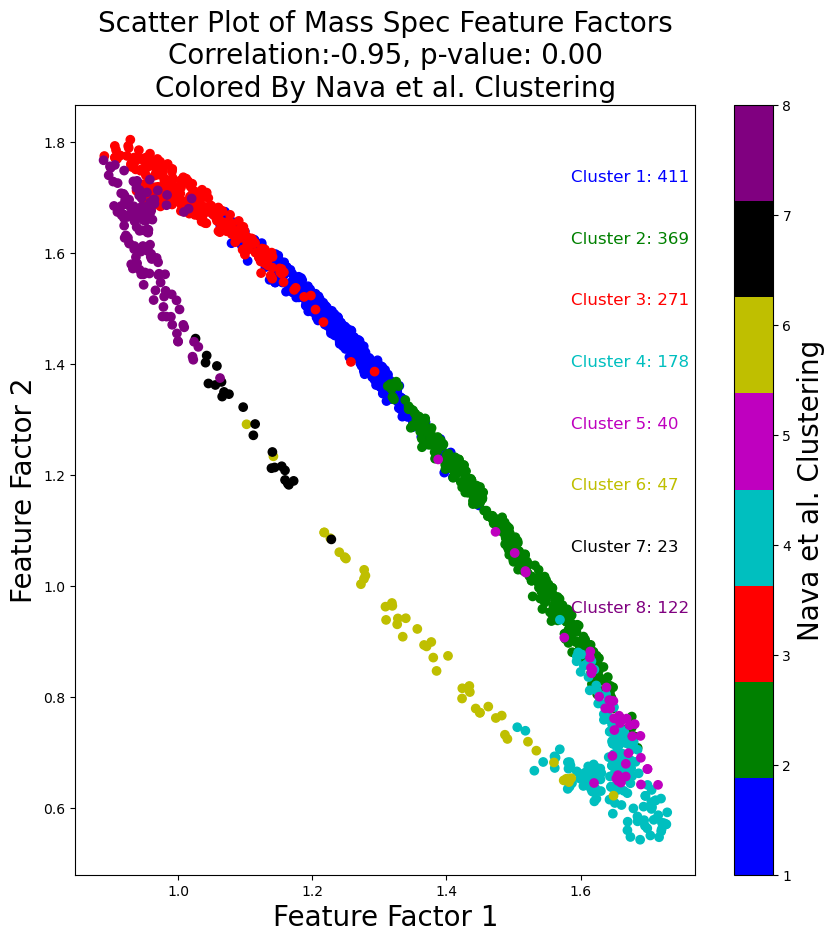

In [133]:
# Create a figure with two subplots
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
#fig.suptitle(f'Factors from Mass Spec', fontsize=30)

# Calculate the correlation and p-value
correlation, p_value = pearsonr(feature_factor1, feature_factor2)

# Customize the color mapping for 8 discrete clusters
cluster_colors = ListedColormap(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple'])
scatter = ax1.scatter(feature_factor1, feature_factor2, c=cluster_ids, cmap=cluster_colors)
ax1.set_title(f'Scatter Plot of Mass Spec Feature Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}\nColored By Nava et al. Clustering', fontsize=20)
cbar = plt.colorbar(scatter, ax=ax1, ticks=range(9))  
cbar.set_label('Nava et al. Clustering', fontsize=20)

# Calculate the size of each cluster
cluster_sizes = [np.sum(cluster_ids == i) for i in range(1,9)]  

# Display the size of each cluster
for i, size in enumerate(cluster_sizes):
    ax1.text(0.8, 0.9 - i * 0.08, f'Cluster {i+1}: {size}', transform=ax1.transAxes, fontsize=12, color=cluster_colors(i))

ax1.set_xlabel('Feature Factor 1', fontsize=20)
ax1.set_ylabel('Feature Factor 2', fontsize=20)

plt.show()


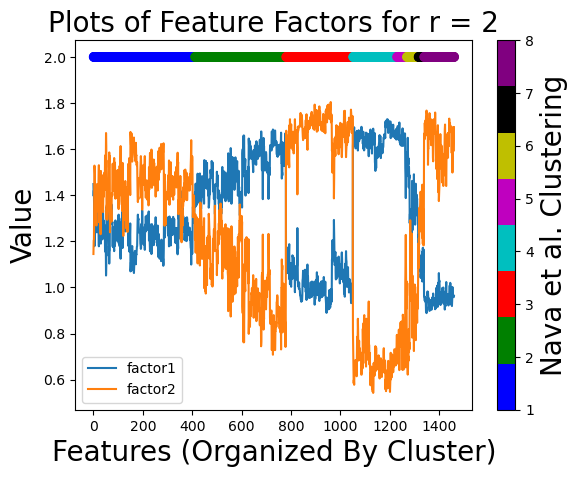

In [134]:
cluster_colors = ListedColormap(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple'])

# Create a plot for the chosen factors
plt.figure()
plt.plot(feature_factor1, label="factor1")
plt.plot(feature_factor2, label="factor2")
plt.title(f'Plots of Feature Factors for r = 2', fontsize=20)
plt.xlabel('Features (Organized By Cluster)', fontsize=20)
plt.ylabel('Value', fontsize=20)
x = np.arange(1, len(feature_factor1) + 1)
y = 2*np.ones(len(feature_factor1))
scatter = plt.scatter(x, y, c=cluster_ids, cmap=cluster_colors)
cbar = plt.colorbar(scatter, ax=plt.gca(), ticks=range(9))
cbar.set_label('Nava et al. Clustering', fontsize=20)
plt.legend()
plt.show()


# Add a straight line that is colored by the values in cluster_ids
#x = np.linspace(min(feature_factor1), max(feature_factor1), 100)
#y = np.linspace(min(feature_factor2), max(feature_factor2), 100)
#colors = np.interp(x, feature_factor1, cluster_ids)
#for i in range(len(feature_factor1)):
#    plt.scatter(x[i], y[i], c=cluster_ids[i], s=10)

#plt.plot(x, y, c=cluster_ids)



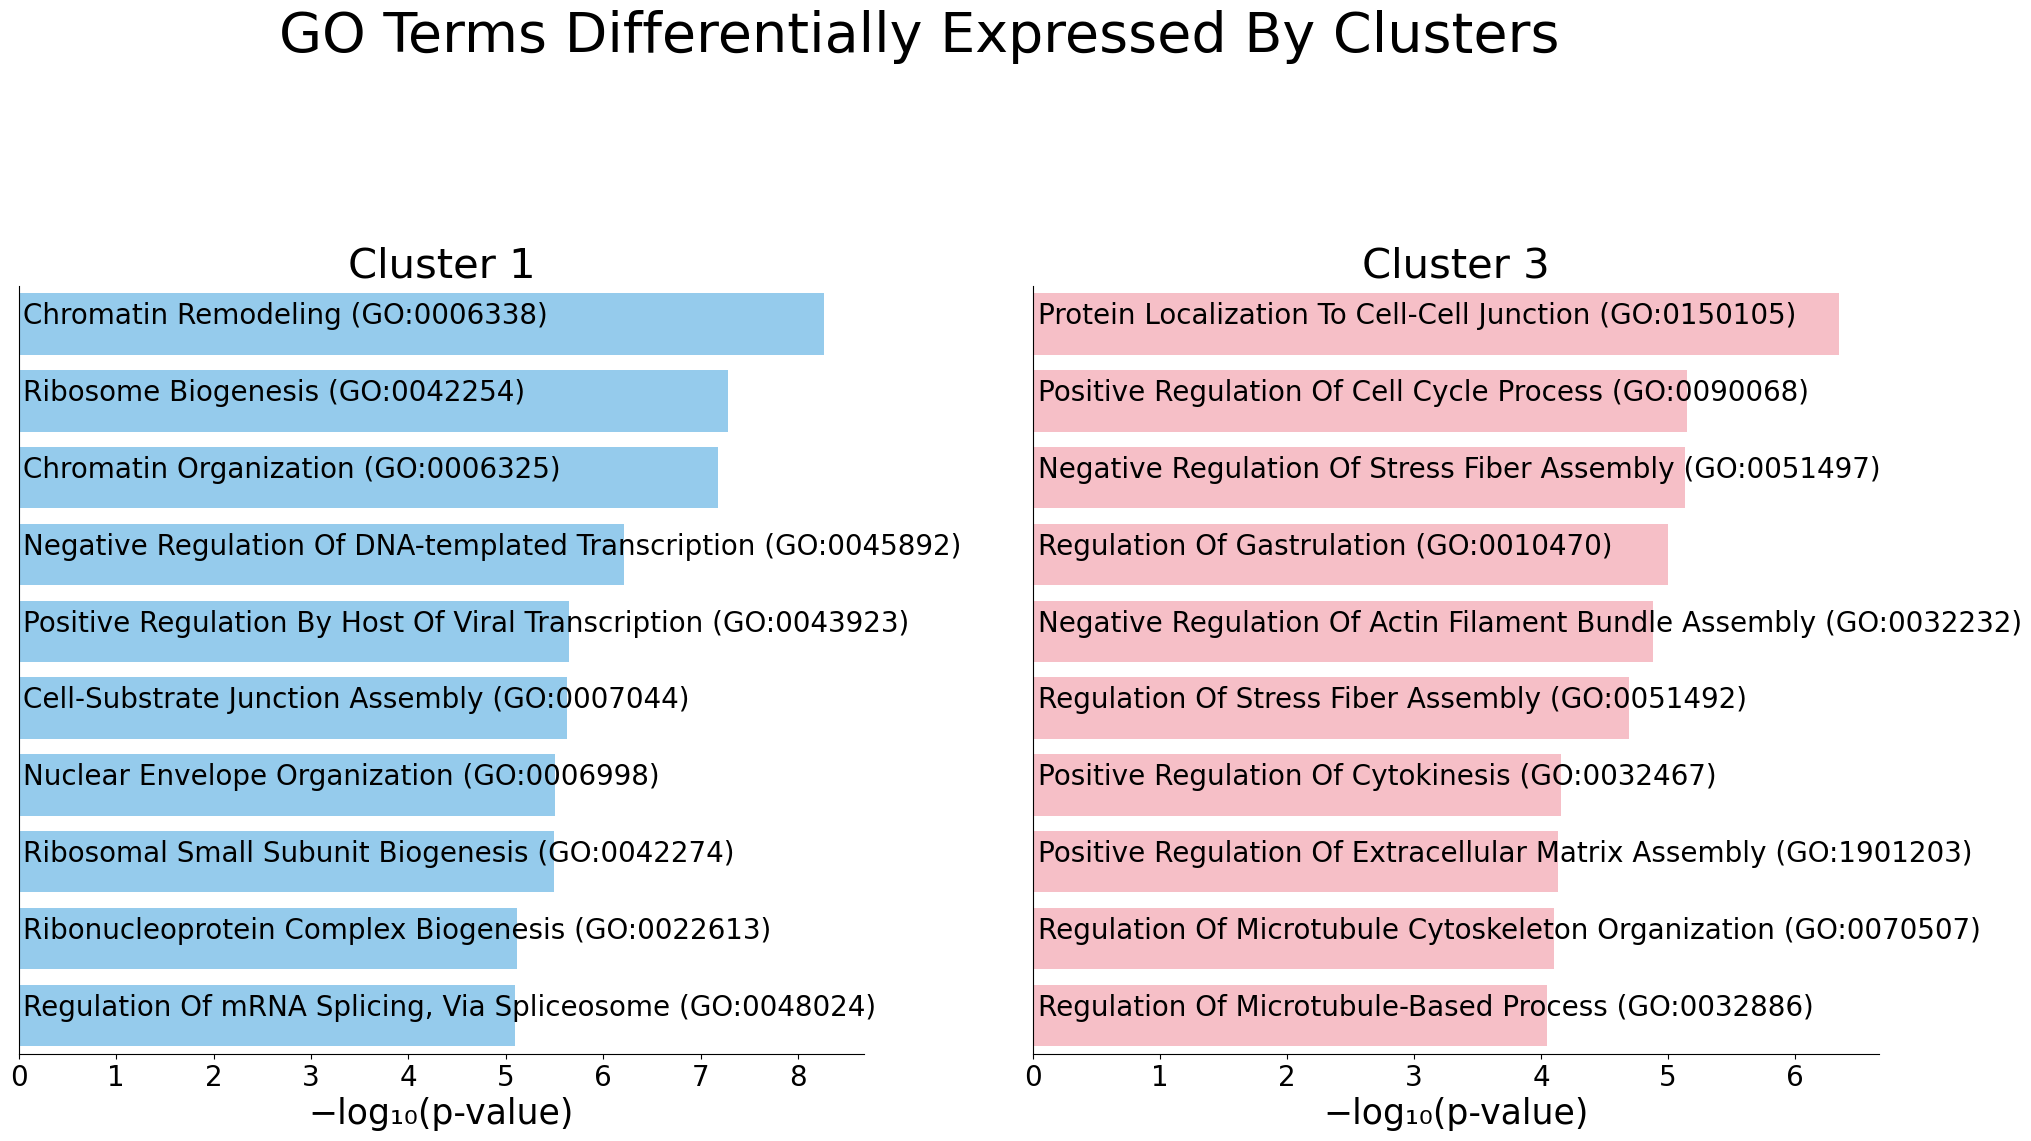

**Figure 1. Bar chart of top enriched terms from the GO_Biological_Process_2023 gene set library.** The top 10     enriched terms for both clusters are displayed based on the -log10(p-value).

/projects/b1198/epifluidlab/david/GSE143519/DE_Pathways.png

/projects/b1198/epifluidlab/david/GSE143519/DE_Pathways.svg

In [135]:
# Bar Chart Parameters
figure_file_format = ['png', 'svg']
output_file_name = 'DE_Pathways'
color = 'lightskyblue'
final_output_file_names = ['{0}.{1}'.format(output_file_name, file_type) for file_type in figure_file_format]
#enrichr_library = 'MSigDB_Hallmark_2020'
enrichr_library = 'GO_Biological_Process_2023'
#enrichr_library = 'GO_Cellular_Component_2023'
#enrichr_library = 'GO_Molecular_Function_2023'
#enrichr_library = 'SynGO_2022'
#enrichr_library = 'GTEx_Aging_Signatures_2021'
#enrichr_library = 'GeneSigDB'

# Initialize a dictionary to store lists for each category
category_lists = {1: [], 2: [], 3: [], 4: [], 5:[], 6:[], 7:[], 8:[]}

# Iterate through the vectors and populate the lists
for gene, category in zip(gene_names, cluster_ids[0]):
    gene = gene.strip()  # Remove trailing whitespace
    category_lists[category].append(gene)    
    
# Access the lists for each category
list1 = category_lists[1]
list2 = category_lists[3]

genes_de_factor1 = [x.strip() for x in list1]
genes_de_factor2 = [x.strip() for x in list2]

genes_upregulated = genes_de_factor1
genes_downregulated = genes_de_factor2 

# Error handling
class NoResults(Exception):
    pass 
class APIFailure(Exception):
    pass

# Enrichr API Function for Manhattan Plot and Bar Chart
# Takes a gene list and Enrichr libraries as input
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    for library_name in all_libraries : 
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = ''
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)

        if len(data[library_name]) == 0:
            raise NoResults

        short_results_df  = pd.DataFrame(data[library_name][0:10])
        all_terms.append(list(short_results_df[1]))
        all_pvalues.append(list(short_results_df[2]))
        all_adjusted_pvalues.append(list(short_results_df[6]))
        
        results_df  = pd.DataFrame(data[library_name])
        # adds library name to the data frame so the libraries can be distinguished
        results_df['library'] = library_name.replace('_', '')

    return [results_df, short_results_df, all_terms, all_pvalues, all_adjusted_pvalues, str(short_id)]

def enrichr_double_figure(up_terms, up_pvalues, up_adjusted_pvalues, down_terms, down_pvalues, down_adjusted_pvalues, plot_names, all_libraries, up_title, down_title):
    # Set bar colors
    edgecolor=None
    linewidth=0
    up_bar_color =  'lightskyblue' 
    down_bar_color = 'lightpink' 
    bar_color_not_sig = 'lightgrey'
    
    plt.figure(figsize=(24, 12))

    # Add a title to the figure
    plt.suptitle("GO Terms Differentially Expressed By Clusters", fontsize=40)
    plt.subplots_adjust(top=0.75)
    # Flatten the nested lists of terms
    up_terms_flat = [term for sublist in up_terms for term in sublist]
    down_terms_flat = [term for sublist in down_terms for term in sublist]

    # Flatten the nested lists of p-values
    up_pvalues_flat = [p for sublist in up_pvalues for p in sublist]
    down_pvalues_flat = [p for sublist in down_pvalues for p in sublist]

    # Plot for factor 1 genes
    plt.subplot(1, 2, 1)
    up_bar_colors = [up_bar_color if (x < 0.05) else bar_color_not_sig for x in up_pvalues_flat]
    up_fig = sns.barplot(x=np.log10(up_pvalues_flat) * -1, y=up_terms_flat, palette=up_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    up_fig.axes.get_yaxis().set_visible(False)
    up_fig.set_title(up_title, fontsize=30)
    up_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    up_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    up_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(up_pvalues_flat) * -1) < 1:
        up_fig.xaxis.set_ticks(np.arange(0, max(np.log10(up_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(up_terms_flat):
        title_start = max(up_fig.axes.get_xlim()) / 200
        up_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=20)
    up_fig.spines['right'].set_visible(False)
    up_fig.spines['top'].set_visible(False)

    # Plot for factor 1 genes
    plt.subplot(1, 2, 2)
    down_bar_colors = [down_bar_color if (x < 0.05) else bar_color_not_sig for x in down_pvalues_flat]
    down_fig = sns.barplot(x=np.log10(down_pvalues_flat) * -1, y=down_terms_flat, palette=down_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    down_fig.axes.get_yaxis().set_visible(False)
    down_fig.set_title(down_title, fontsize=30)
    down_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    down_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    down_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(down_pvalues_flat) * -1) < 1:
        down_fig.xaxis.set_ticks(np.arange(0, max(np.log10(down_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(down_terms_flat):
        title_start = max(down_fig.axes.get_xlim()) / 200
        down_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=20)
    down_fig.spines['right'].set_visible(False)
    down_fig.spines['top'].set_visible(False)

    for plot_name in plot_names:
        plt.savefig(plot_name, bbox_inches='tight')

    # Show plot
    plt.show()

    
#Display Bar Chart
caption5 = f"**Figure 1. Bar chart of top enriched terms from the {enrichr_library} gene set library.** The top 10 \
    enriched terms for both clusters are displayed based on the -log10(p-value)."

try:
    results_upregulated = Enrichr_API(genes_upregulated, [enrichr_library])
    results_downregulated = Enrichr_API(genes_downregulated, [enrichr_library])
    upregulated_title = 'Cluster 1'
    downregulated_title = 'Cluster 3'
    enrichr_double_figure(results_upregulated[2], results_upregulated[3], results_upregulated[4],
                      results_downregulated[2], results_downregulated[3], results_downregulated[4],
                      final_output_file_names, [enrichr_library], upregulated_title, downregulated_title)
    display(Markdown(caption5))
    # Download Bar Chart
    for i, file in enumerate(final_output_file_names):
        display(FileLink(file, result_html_prefix=str('Download ' + figure_file_format[i] + ': ')))
except APIFailure:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because of a bad response from the Enrichr API</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later."))
except NoResults:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))    

In [136]:

# Input Excel file and output HDF5 file paths
xlsx_file_path = '/home/dwk681/workspace/GSE143519/mmc1.xlsx'
hdf5_file_path = '/home/dwk681/workspace/GSE143519/Workspaces/zscore_0stress_or_40stress_30mins_360mins_3_replicates_NaN/'

# Open the Excel file using openpyxl
workbook = openpyxl.load_workbook(xlsx_file_path)

# Select the first sheet (you may need to specify the sheet name if not the first sheet)
sheet = workbook.active 

# Create lists for the 8th and 11th columns
column_1 = []
column_3 = []
column_4 = []
column_5 = []
column_6 = []
column_7 = []
column_8 = []
column_9 = []
column_10 = []
column_11 = []
column_12 = []
column_13 = []

# Iterate through the rows and extract data from the columns
for row in sheet.iter_rows(min_row=2, values_only=True):
    column_1.append(row[0])  
    column_3.append(row[2])
    column_4.append(row[3])
    column_5.append(row[4])   
    column_6.append(row[5])  
    column_7.append(row[6])   
    column_8.append(row[7])
    column_9.append(row[8])   
    column_10.append(row[9])  
    column_11.append(row[10])
    column_12.append(row[11])   
    column_13.append(row[12]) 



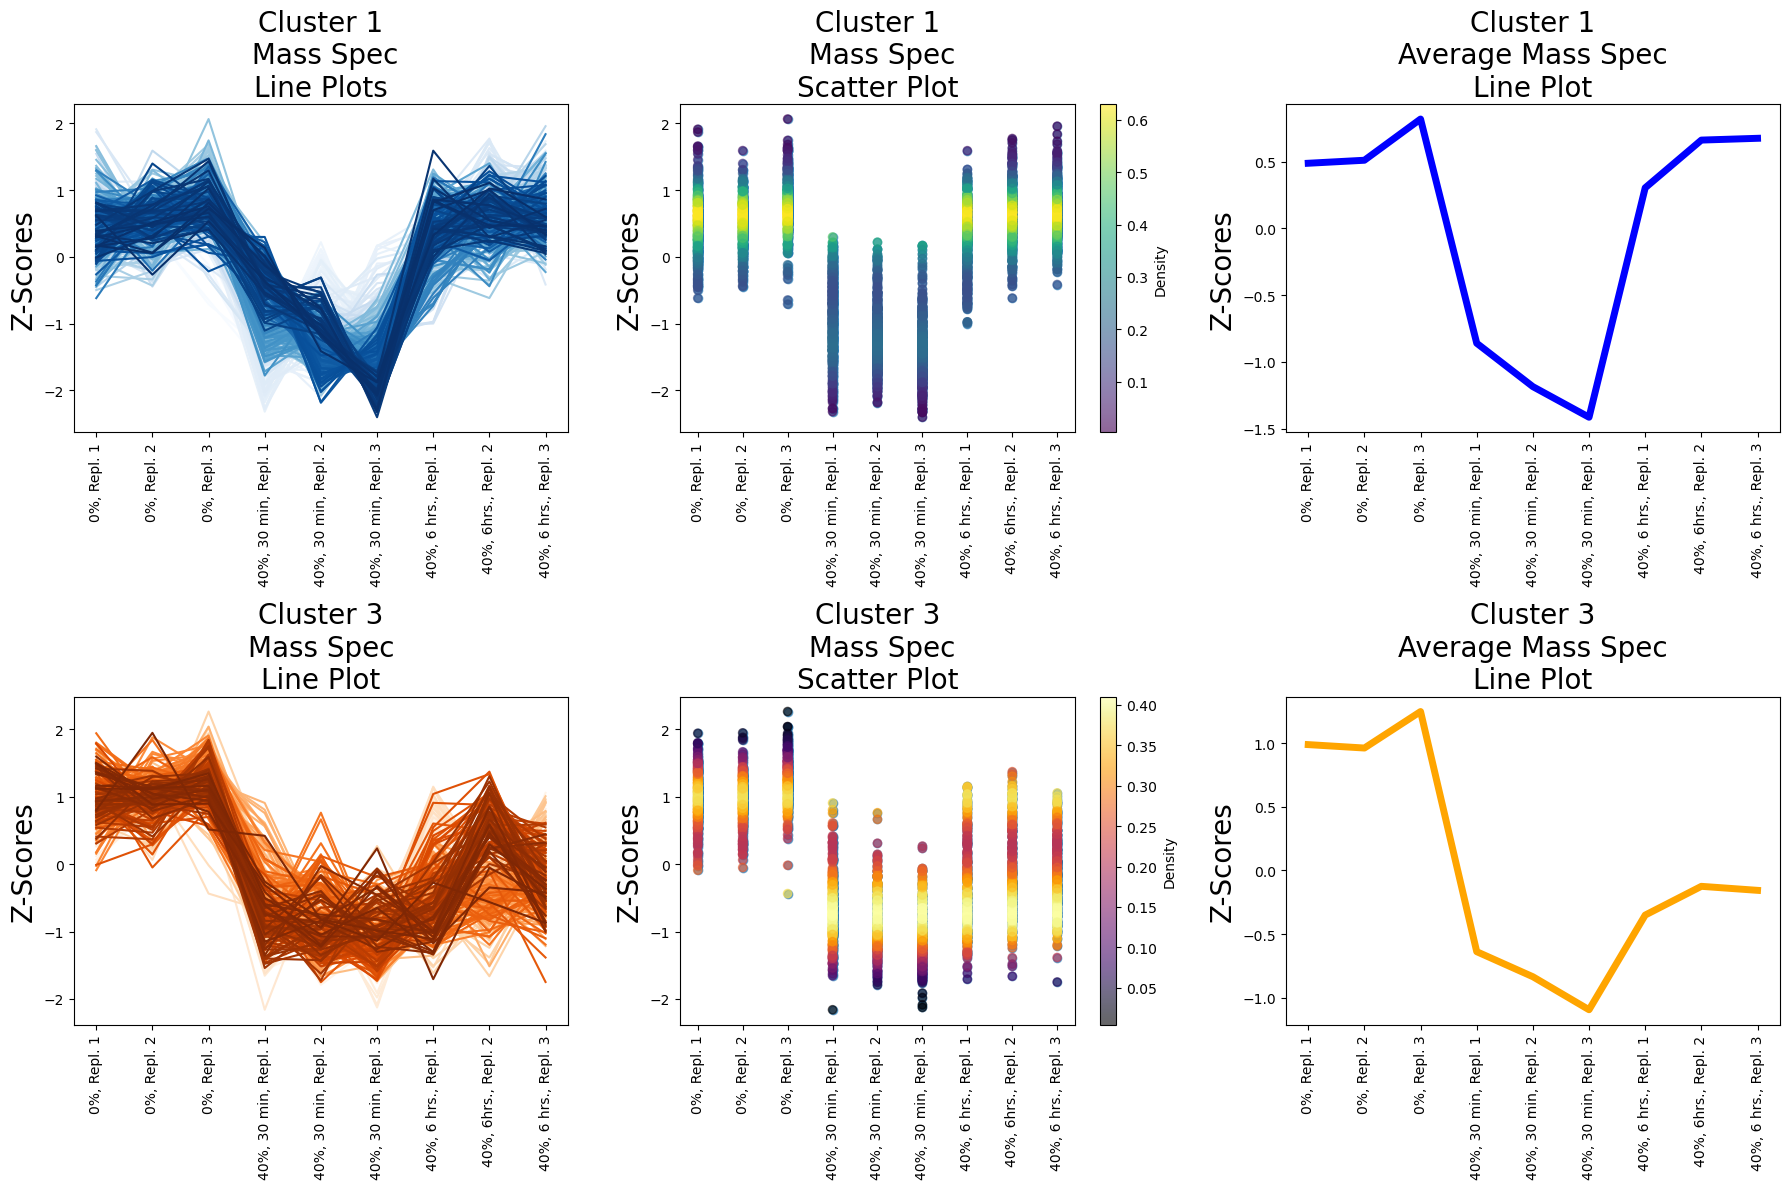

In [137]:
#This code plots the expression levels of the Two Clusters

# Create a list to store the vectors
vectors_category1 = []
vectors_category2 = []
vectors_category3 = []

for i in range(len(cluster_ids[0])):
    if cluster_ids[0][i] == 1:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category1.append(vector) 
    if cluster_ids[0][i] == 3:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category2.append(vector)
    else:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category3.append(vector)
        
vectors_category1_array = np.array(vectors_category1)
vectors_category2_array = np.array(vectors_category2)
vectors_category3_array = np.array(vectors_category3)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
colors_category1 = plt.cm.Blues(np.linspace(0, 1, len(vectors_category1_array)))
colors_category2 = plt.cm.Oranges(np.linspace(0, 1, len(vectors_category2_array)))
x_labels = ['0%, Repl. 1', '0%, Repl. 2', '0%, Repl. 3', '40%, 30 min, Repl. 1', '40%, 30 min, Repl. 2', '40%, 30 min, Repl. 3', '40%, 6 hrs., Repl. 1', '40%, 6hrs., Repl. 2', '40%, 6 hrs., Repl. 3']
x_values = np.arange(len(vectors_category2_array[0]))

# [0,0] subplot
for i, (vector, color) in enumerate(zip(vectors_category1_array, colors_category1)):
    axs[0, 0].plot(vector, label=f'Cluster 1', color=color)
axs[0, 0].set_xticks(range(len(x_labels)))
axs[0, 0].set_xticklabels(x_labels, rotation='vertical')
axs[0, 0].set_ylabel('Z-Scores', fontsize=20)
axs[0, 0].set_title('Cluster 1\n Mass Spec\nLine Plots', fontsize=20)

# [0,1] subplot
n = len(vectors_category1_array)
x = np.tile(np.arange(0,9), n)
y = np.hstack(vectors_category1_array)  
scatter = axs[0, 1].scatter(x, y, marker='o', alpha=0.6)
kde = gaussian_kde(y)
density = kde(y)
scatter = axs[0, 1].scatter(x, y, c=density, cmap='viridis', marker='o', alpha=0.6)
cbar = fig.colorbar(scatter, ax=axs[0, 1], label='Density')
axs[0, 1].set_xticks(range(len(x_labels)))
axs[0, 1].set_xticklabels(x_labels, rotation='vertical')
axs[0, 1].set_ylabel('Z-Scores', fontsize=20)
axs[0, 1].set_title('Cluster 1\n Mass Spec\nScatter Plot', fontsize=20)

# [0,2] subplot
average_vector_category1 = np.mean(vectors_category1_array, axis=0)
line = axs[0, 2].plot(average_vector_category1, label='Average Cluster 1', color='blue')
axs[0, 2].set_xticks(range(len(x_labels)))
axs[0, 2].set_xticklabels(x_labels, rotation='vertical')
axs[0, 2].set_ylabel('Z-Scores', fontsize=20)
axs[0, 2].set_title('Cluster 1\nAverage Mass Spec\nLine Plot', fontsize=20)
line[0].set_linewidth(5.0)

# [1,0] subplot
for i, (vector, color) in enumerate(zip(vectors_category2_array, colors_category2)):
    axs[1, 0].plot(vector, label=f'Cluster 2', color=color)
axs[1, 0].set_ylabel('Z-Scores', fontsize=20)
axs[1, 0].set_title('Cluster 3\nMass Spec\nLine Plot', fontsize=20)
axs[1, 0].set_xticks(range(len(x_labels)))
axs[1, 0].set_xticklabels(x_labels, rotation='vertical')

# [1,1] subplot
n = len(vectors_category2_array)
x = np.tile(np.arange(0, 9), n)
y = np.hstack(vectors_category2_array)  
scatter = axs[1, 1].scatter(x, y, marker='o', alpha=0.6)
kde = gaussian_kde(y)
density = kde(y)
scatter = axs[1, 1].scatter(x, y, c=density, cmap='inferno', marker='o', alpha=0.6)
cbar = fig.colorbar(scatter, ax=axs[1, 1], label='Density')
axs[1, 1].set_xticks(range(len(x_labels)))
axs[1, 1].set_xticklabels(x_labels, rotation='vertical')
axs[1, 1].set_ylabel('Z-Scores', fontsize=20)
axs[1, 1].set_title('Cluster 3\n Mass Spec\nScatter Plot', fontsize=20)




# [1,2] subplot
average_vector_category2 = np.mean(vectors_category2_array, axis=0)
line = axs[1, 2].plot(average_vector_category2, label='Average Cluster 3', color='orange')
axs[1, 2].set_ylabel('Z-Scores', fontsize=20)
axs[1, 2].set_title('Cluster 3\nAverage Mass Spec\nLine Plot',fontsize=20)
axs[1, 2].set_xticks(range(len(x_labels)))
axs[1, 2].set_xticklabels(x_labels, rotation='vertical')
line[0].set_linewidth(5.0)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


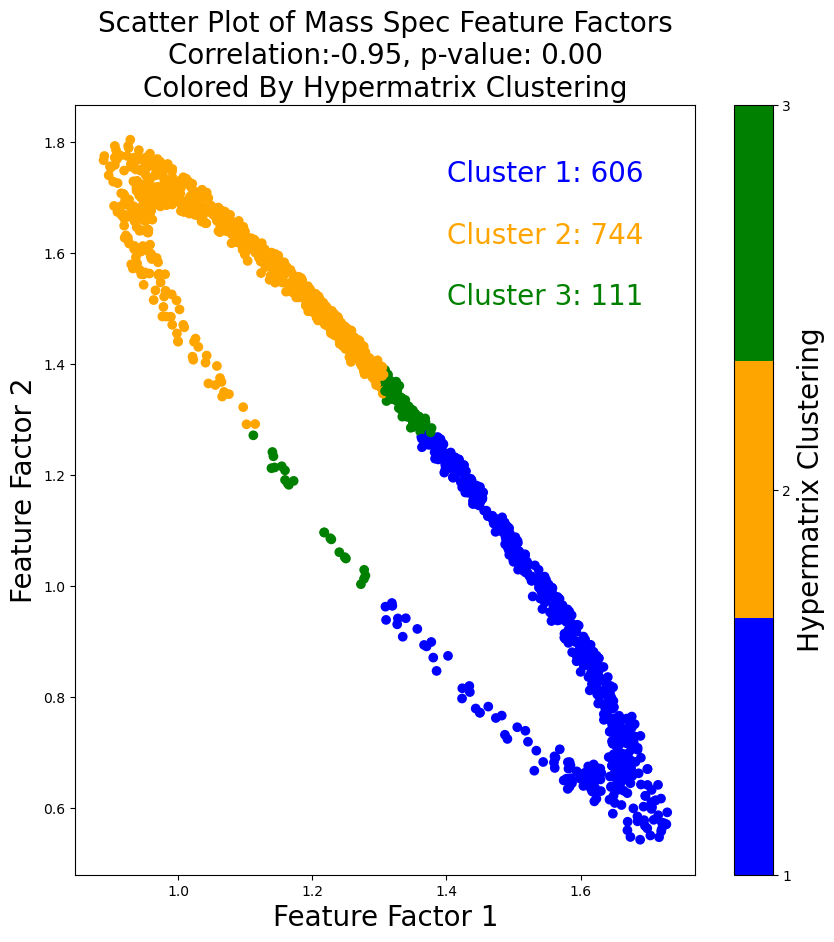

In [138]:
# Assuming you have feature_factor1 and feature_factor2 defined

# Calculate the mean values of feature_factor1 and feature_factor2 across all bins
mean_feature_factor1 = np.mean(feature_factor1)
mean_feature_factor2 = np.mean(feature_factor2)

# Loop over each bin and compare the values of feature_factor1 and feature_factor2 to the mean values to determine the category
categories = []
for i in range(len(feature_factor1)):
    if feature_factor1[i] > mean_feature_factor1 and feature_factor2[i] < mean_feature_factor2:
        categories.append(1)
    elif feature_factor2[i] > mean_feature_factor2 and feature_factor1[i] < mean_feature_factor1:
        categories.append(2)
    else:
        categories.append(3)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
#fig.suptitle(f'Factors from Mass Spec', fontsize=30)

# Calculate the correlation and p-value
correlation, p_value = pearsonr(feature_factor1, feature_factor2)

# Customize the color mapping for 8 discrete clusters
cluster_colors = ListedColormap(['b', 'orange', 'green'])
scatter = ax1.scatter(feature_factor1, feature_factor2, c=categories, cmap=cluster_colors)
ax1.set_title(f'Scatter Plot of Mass Spec Feature Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}\nColored By Hypermatrix Clustering', fontsize=20)
cbar = plt.colorbar(scatter, ax=ax1, ticks=range(1,4))  #
cbar.set_label('Hypermatrix Clustering', fontsize=20)

# Calculate the size of each cluster
cluster_sizes = [np.sum([category == i for category in categories]) for i in range(1,4)]  

# Display the size of each cluster
for i, size in enumerate(cluster_sizes):
    ax1.text(0.6, 0.9 - i * 0.08, f'Cluster {i+1}: {size}', transform=ax1.transAxes, fontsize=20, color=cluster_colors(i))

ax1.set_xlabel('Feature Factor 1', fontsize=20)
ax1.set_ylabel('Feature Factor 2', fontsize=20)

plt.show()

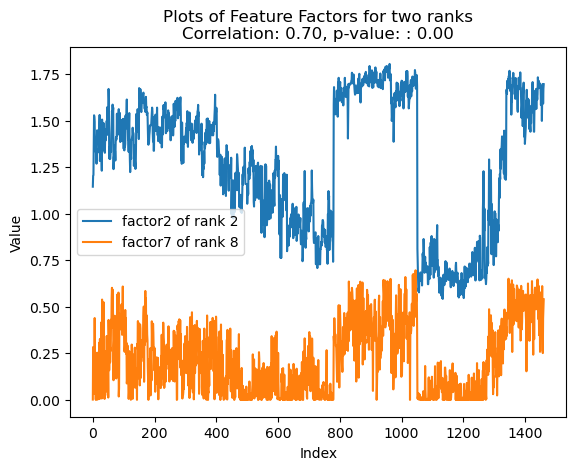

In [139]:
feature_factor1_rank8 = sol_factors[0][7][0][0][:,6]
feature_factor1_rank2 = sol_factors[0][1][0][0][:,1]

correlation, p_value = pearsonr(feature_factor1_rank8, feature_factor1_rank2)

plt.figure()
plt.plot(feature_factor1_rank2, label="factor2 of rank 2")
plt.plot(.2*feature_factor1_rank8, label="factor7 of rank 8")
plt.title(f'Plots of Feature Factors for two ranks\nCorrelation: {correlation:.2f}, p-value: : {p_value:.2f}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


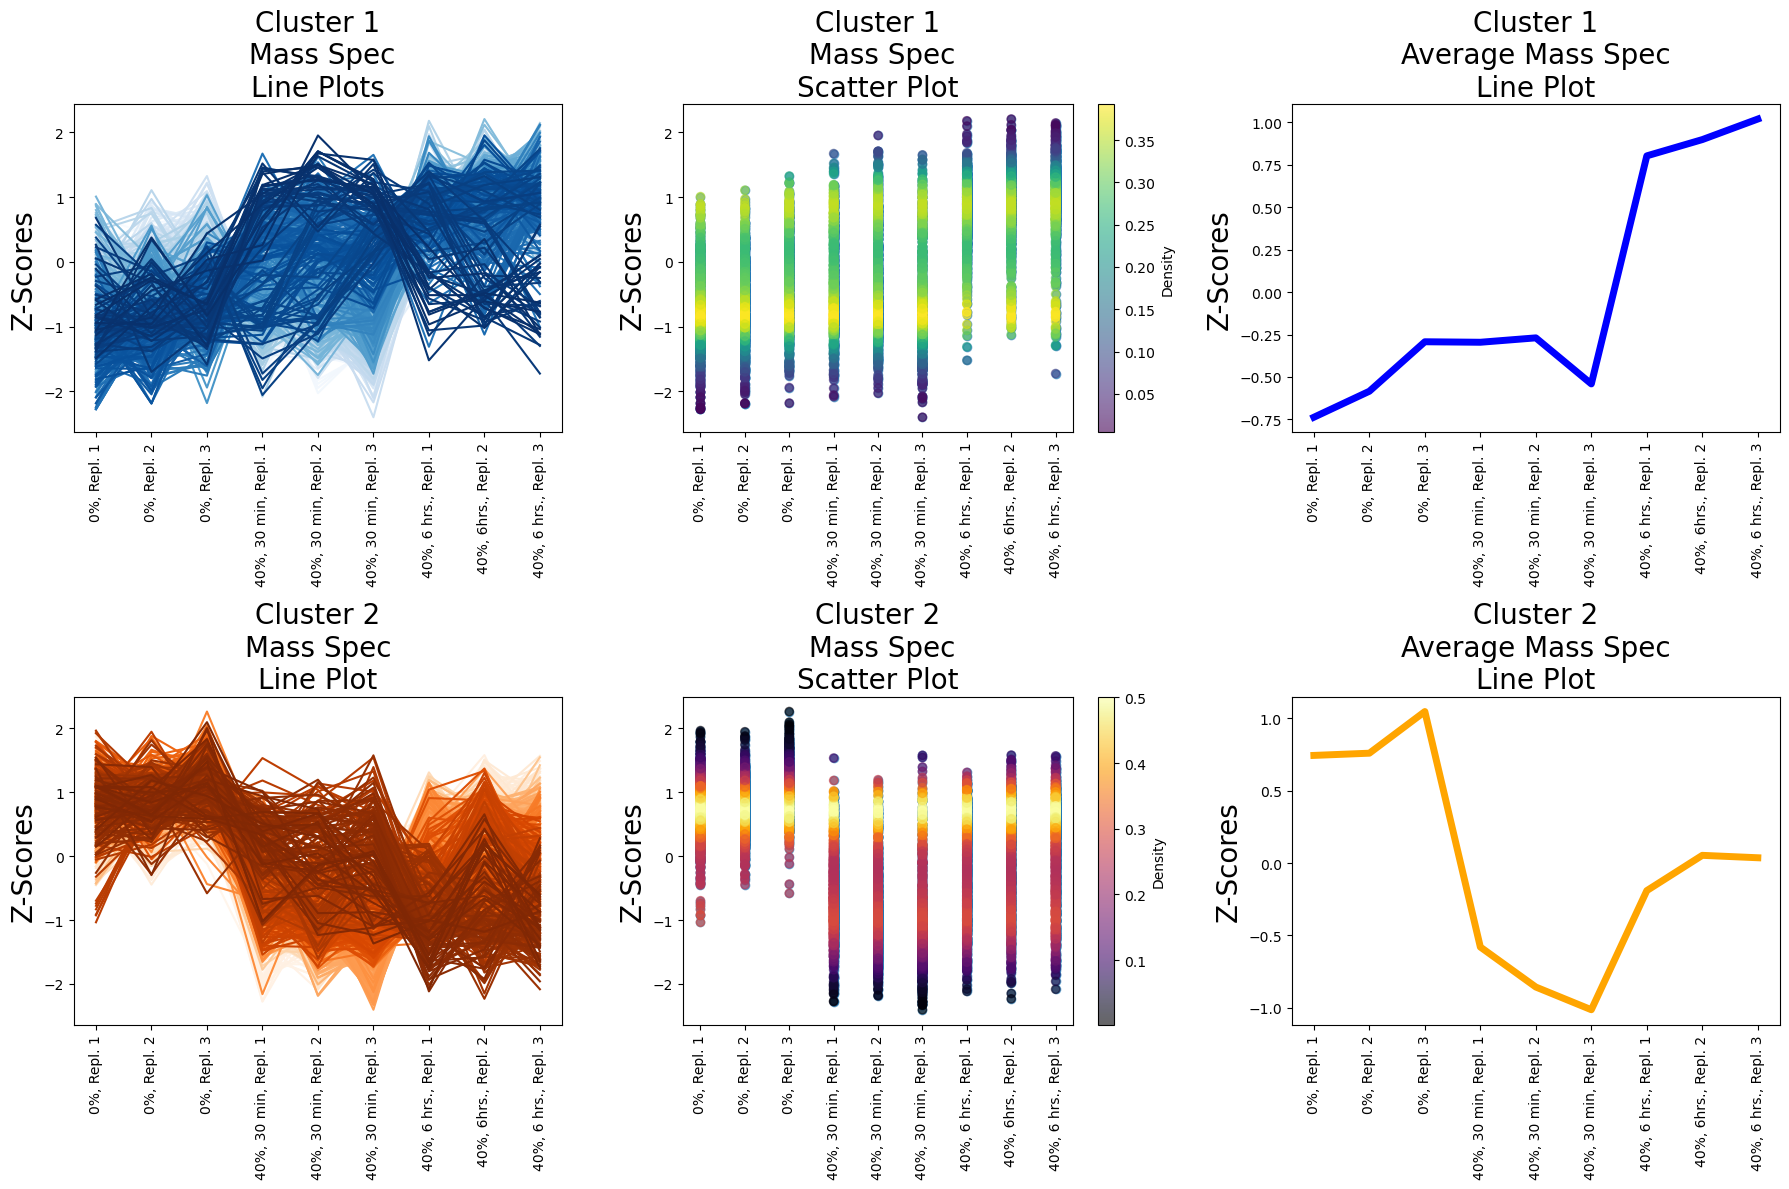

In [140]:
#This code plots the expression levels of the Two Clusters

# Create a list to store the vectors
vectors_category1 = []
vectors_category2 = []
vectors_category3 = []

# Iterate through the categories and extract vectors for categories[i] == 1
for i in range(len(categories)):
    if categories[i] == 1:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category1.append(vector) 
    if categories[i] == 2:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category2.append(vector)
    else:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category3.append(vector)
        
vectors_category1_array = np.array(vectors_category1)
vectors_category2_array = np.array(vectors_category2)
vectors_category3_array = np.array(vectors_category3)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
colors_category1 = plt.cm.Blues(np.linspace(0, 1, len(vectors_category1_array)))
colors_category2 = plt.cm.Oranges(np.linspace(0, 1, len(vectors_category2_array)))
x_labels = ['0%, Repl. 1', '0%, Repl. 2', '0%, Repl. 3', '40%, 30 min, Repl. 1', '40%, 30 min, Repl. 2', '40%, 30 min, Repl. 3', '40%, 6 hrs., Repl. 1', '40%, 6hrs., Repl. 2', '40%, 6 hrs., Repl. 3']
x_values = np.arange(len(vectors_category2_array[0]))

# [0,0] subplot
for i, (vector, color) in enumerate(zip(vectors_category1_array, colors_category1)):
    axs[0, 0].plot(vector, label=f'Cluster 1', color=color)
axs[0, 0].set_xticks(range(len(x_labels)))
axs[0, 0].set_xticklabels(x_labels, rotation='vertical')
axs[0, 0].set_ylabel('Z-Scores', fontsize=20)
axs[0, 0].set_title('Cluster 1\n Mass Spec\nLine Plots', fontsize=20)

# [0,1] subplot
n = len(vectors_category1_array)
x = np.tile(np.arange(0,9), n)
y = np.hstack(vectors_category1_array)  
scatter = axs[0, 1].scatter(x, y, marker='o', alpha=0.6)
kde = gaussian_kde(y)
density = kde(y)
scatter = axs[0, 1].scatter(x, y, c=density, cmap='viridis', marker='o', alpha=0.6)
cbar = fig.colorbar(scatter, ax=axs[0, 1], label='Density')
axs[0, 1].set_xticks(range(len(x_labels)))
axs[0, 1].set_xticklabels(x_labels, rotation='vertical')
axs[0, 1].set_ylabel('Z-Scores', fontsize=20)
axs[0, 1].set_title('Cluster 1\n Mass Spec\nScatter Plot', fontsize=20)

# [0,2] subplot
average_vector_category1 = np.mean(vectors_category1_array, axis=0)
line = axs[0, 2].plot(average_vector_category1, label='Average Cluster 1', color='blue')
axs[0, 2].set_xticks(range(len(x_labels)))
axs[0, 2].set_xticklabels(x_labels, rotation='vertical')
axs[0, 2].set_ylabel('Z-Scores', fontsize=20)
axs[0, 2].set_title('Cluster 1\nAverage Mass Spec\nLine Plot', fontsize=20)
line[0].set_linewidth(5.0)

# [1,0] subplot
for i, (vector, color) in enumerate(zip(vectors_category2_array, colors_category2)):
    axs[1, 0].plot(vector, label=f'Cluster 2', color=color)
axs[1, 0].set_ylabel('Z-Scores', fontsize=20)
axs[1, 0].set_title('Cluster 2\nMass Spec\nLine Plot', fontsize=20)
axs[1, 0].set_xticks(range(len(x_labels)))
axs[1, 0].set_xticklabels(x_labels, rotation='vertical')

# [1,1] subplot
n = len(vectors_category2_array)
x = np.tile(np.arange(0, 9), n)
y = np.hstack(vectors_category2_array)  
scatter = axs[1, 1].scatter(x, y, marker='o', alpha=0.6)
kde = gaussian_kde(y)
density = kde(y)
scatter = axs[1, 1].scatter(x, y, c=density, cmap='inferno', marker='o', alpha=0.6)
cbar = fig.colorbar(scatter, ax=axs[1, 1], label='Density')
axs[1, 1].set_xticks(range(len(x_labels)))
axs[1, 1].set_xticklabels(x_labels, rotation='vertical')
axs[1, 1].set_ylabel('Z-Scores', fontsize=20)
axs[1, 1].set_title('Cluster 2\n Mass Spec\nScatter Plot', fontsize=20)




# [1,2] subplot
average_vector_category2 = np.mean(vectors_category2_array, axis=0)
line = axs[1, 2].plot(average_vector_category2, label='Average Cluster 2', color='orange')
axs[1, 2].set_ylabel('Z-Scores', fontsize=20)
axs[1, 2].set_title('Cluster 2\nAverage Mass Spec\nLine Plot',fontsize=20)
axs[1, 2].set_xticks(range(len(x_labels)))
axs[1, 2].set_xticklabels(x_labels, rotation='vertical')
line[0].set_linewidth(5.0)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


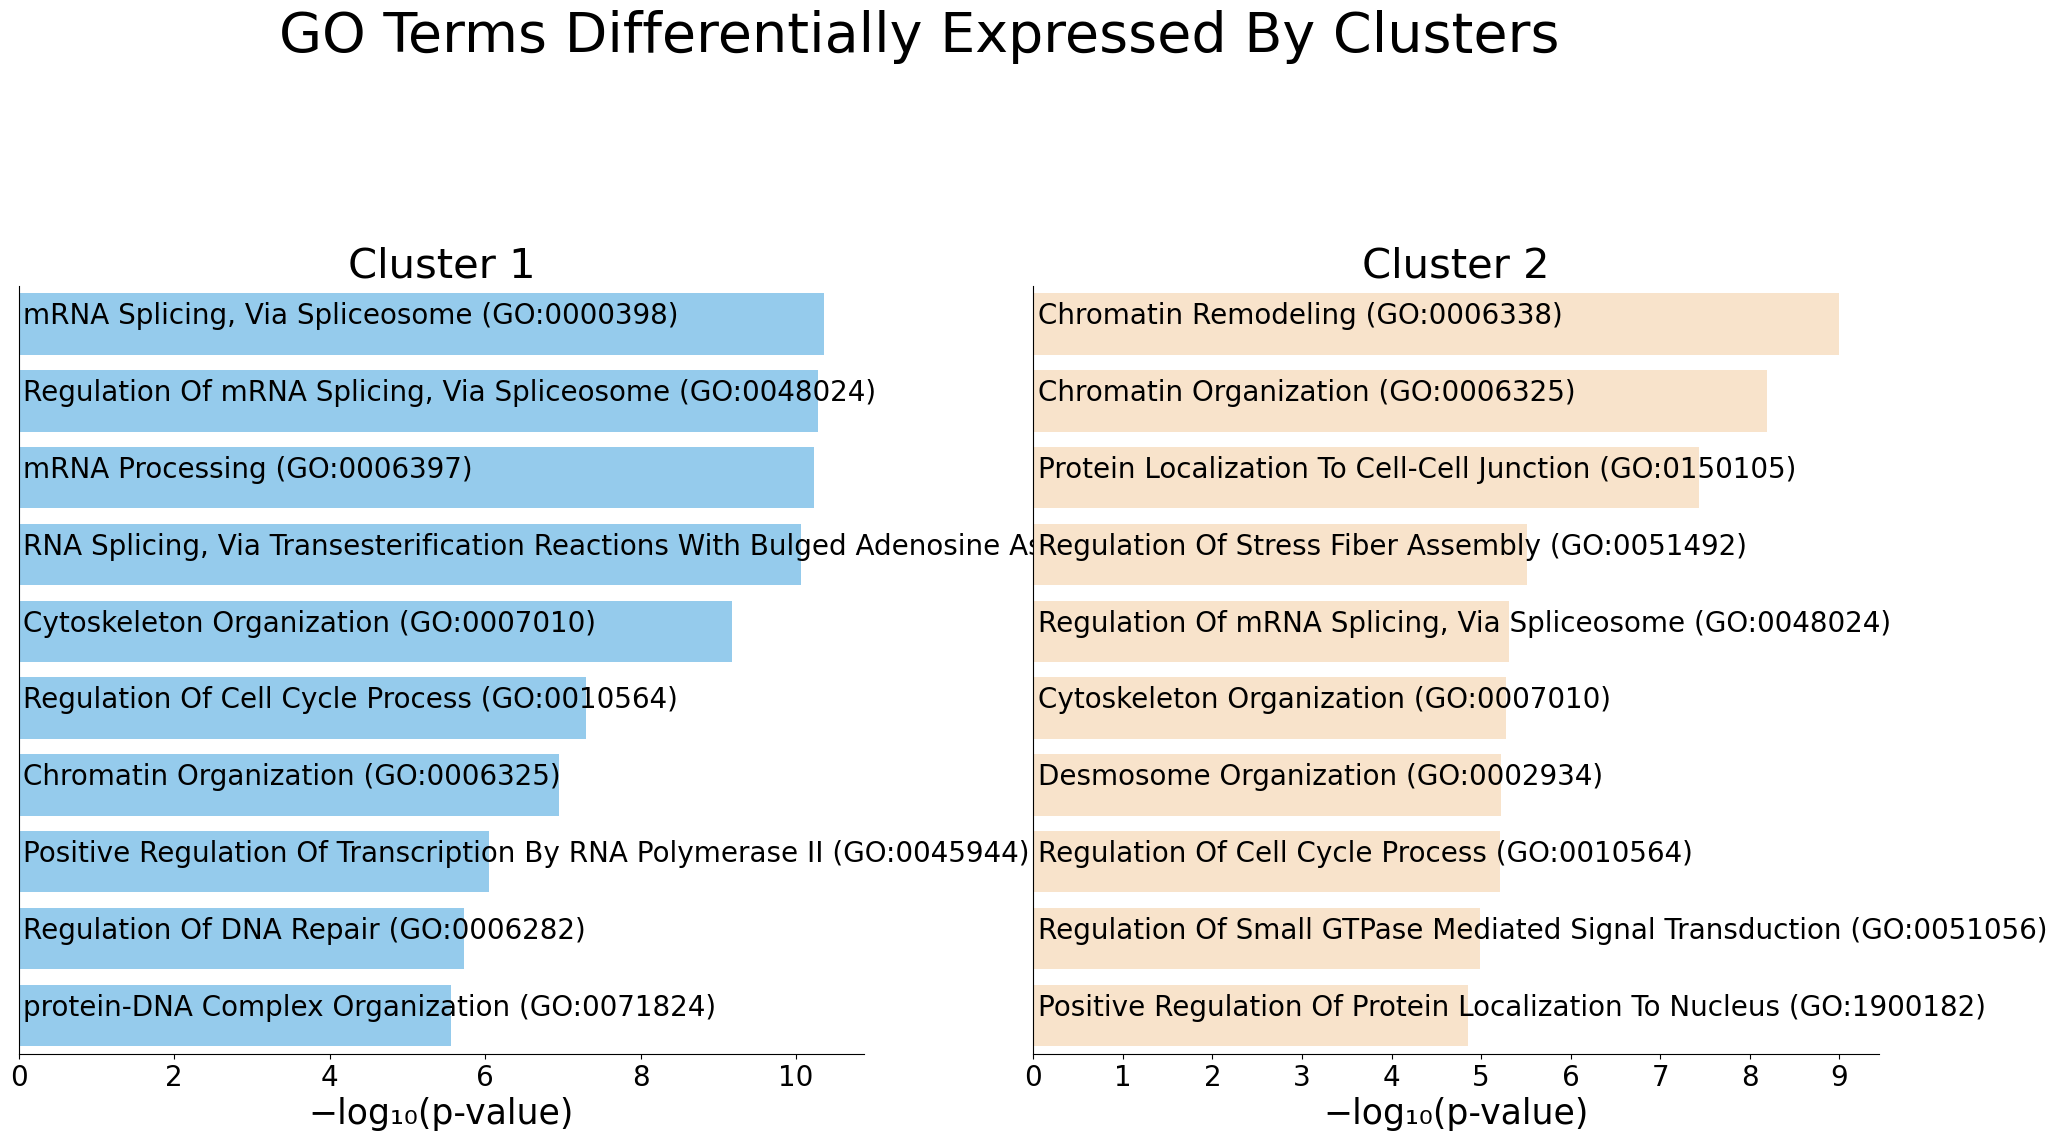

**Figure 1. Bar chart of top enriched terms from the GO_Biological_Process_2023 gene set library.** The top 10     enriched for GO terms are displayed based on the -log10(p-value).

/projects/b1198/epifluidlab/david/GSE143519/DE_Pathways.png

/projects/b1198/epifluidlab/david/GSE143519/DE_Pathways.svg

In [142]:
# Bar Chart Parameters
figure_file_format = ['png', 'svg']
output_file_name = 'DE_Pathways'
color = 'lightskyblue'
final_output_file_names = ['{0}.{1}'.format(output_file_name, file_type) for file_type in figure_file_format]
#enrichr_library = 'MSigDB_Hallmark_2020'
enrichr_library = 'GO_Biological_Process_2023'
#enrichr_library = 'GO_Cellular_Component_2023'

# Initialize a dictionary to store lists for each category
category_lists = {1: [], 2: [], 3: []}

# Iterate through the vectors and populate the lists
for gene, category in zip(gene_names, categories):
    gene = gene.strip()  # Remove trailing whitespace
    category_lists[category].append(gene)    
    
# Access the lists for each category
list1 = category_lists[1]
list2 = category_lists[2]
list3 = category_lists[3]

genes_de_factor1 = [x.strip() for x in list1]
genes_de_factor2 = [x.strip() for x in list2]

genes_upregulated = genes_de_factor1
genes_downregulated = genes_de_factor2 

# Error handling
class NoResults(Exception):
    pass 
class APIFailure(Exception):
    pass

# Enrichr API Function for Manhattan Plot and Bar Chart
# Takes a gene list and Enrichr libraries as input
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    for library_name in all_libraries : 
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = ''
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)

        if len(data[library_name]) == 0:
            raise NoResults

        short_results_df  = pd.DataFrame(data[library_name][0:10])
        all_terms.append(list(short_results_df[1]))
        all_pvalues.append(list(short_results_df[2]))
        all_adjusted_pvalues.append(list(short_results_df[6]))
        
        results_df  = pd.DataFrame(data[library_name])
        # adds library name to the data frame so the libraries can be distinguished
        results_df['library'] = library_name.replace('_', '')

    return [results_df, short_results_df, all_terms, all_pvalues, all_adjusted_pvalues, str(short_id)]

def enrichr_double_figure(up_terms, up_pvalues, up_adjusted_pvalues, down_terms, down_pvalues, down_adjusted_pvalues, plot_names, all_libraries, up_title, down_title):
    # Set bar colors
    edgecolor=None
    linewidth=0
    up_bar_color =  'lightskyblue'   #shade of red
    down_bar_color = 'bisque'  #shade of blue
    bar_color_not_sig = 'lightgrey'
    
    plt.figure(figsize=(24, 12))

    # Add a title to the figure
    plt.suptitle("GO Terms Differentially Expressed By Clusters", fontsize=40)
    plt.subplots_adjust(top=0.75)
    # Flatten the nested lists of terms
    up_terms_flat = [term for sublist in up_terms for term in sublist]
    down_terms_flat = [term for sublist in down_terms for term in sublist]

    # Flatten the nested lists of p-values
    up_pvalues_flat = [p for sublist in up_pvalues for p in sublist]
    down_pvalues_flat = [p for sublist in down_pvalues for p in sublist]

    # Plot for factor 1 genes
    plt.subplot(1, 2, 1)
    up_bar_colors = [up_bar_color if (x < 0.05) else bar_color_not_sig for x in up_pvalues_flat]
    up_fig = sns.barplot(x=np.log10(up_pvalues_flat) * -1, y=up_terms_flat, palette=up_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    up_fig.axes.get_yaxis().set_visible(False)
    up_fig.set_title(up_title, fontsize=30)
    up_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    up_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    up_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(up_pvalues_flat) * -1) < 1:
        up_fig.xaxis.set_ticks(np.arange(0, max(np.log10(up_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(up_terms_flat):
        title_start = max(up_fig.axes.get_xlim()) / 200
        up_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=20)
    up_fig.spines['right'].set_visible(False)
    up_fig.spines['top'].set_visible(False)

    # Plot for factor 1 genes
    plt.subplot(1, 2, 2)
    down_bar_colors = [down_bar_color if (x < 0.05) else bar_color_not_sig for x in down_pvalues_flat]
    down_fig = sns.barplot(x=np.log10(down_pvalues_flat) * -1, y=down_terms_flat, palette=down_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    down_fig.axes.get_yaxis().set_visible(False)
    down_fig.set_title(down_title, fontsize=30)
    down_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    down_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    down_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(down_pvalues_flat) * -1) < 1:
        down_fig.xaxis.set_ticks(np.arange(0, max(np.log10(down_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(down_terms_flat):
        title_start = max(down_fig.axes.get_xlim()) / 200
        down_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=20)
    down_fig.spines['right'].set_visible(False)
    down_fig.spines['top'].set_visible(False)

    for plot_name in plot_names:
        plt.savefig(plot_name, bbox_inches='tight')

    # Show plot
    plt.show()

    
#Display Bar Chart
caption5 = f"**Figure 1. Bar chart of top enriched terms from the {enrichr_library} gene set library.** The top 10 \
    enriched for GO terms are displayed based on the -log10(p-value)."

try:
    results_upregulated = Enrichr_API(genes_upregulated, [enrichr_library])
    results_downregulated = Enrichr_API(genes_downregulated, [enrichr_library])
    upregulated_title = 'Cluster 1'
    downregulated_title = 'Cluster 2'
    enrichr_double_figure(results_upregulated[2], results_upregulated[3], results_upregulated[4],
                      results_downregulated[2], results_downregulated[3], results_downregulated[4],
                      final_output_file_names, [enrichr_library], upregulated_title, downregulated_title)
    display(Markdown(caption5))
    # Download Bar Chart
    for i, file in enumerate(final_output_file_names):
        display(FileLink(file, result_html_prefix=str('Download ' + figure_file_format[i] + ': ')))
except APIFailure:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because of a bad response from the Enrichr API</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later."))
except NoResults:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))    

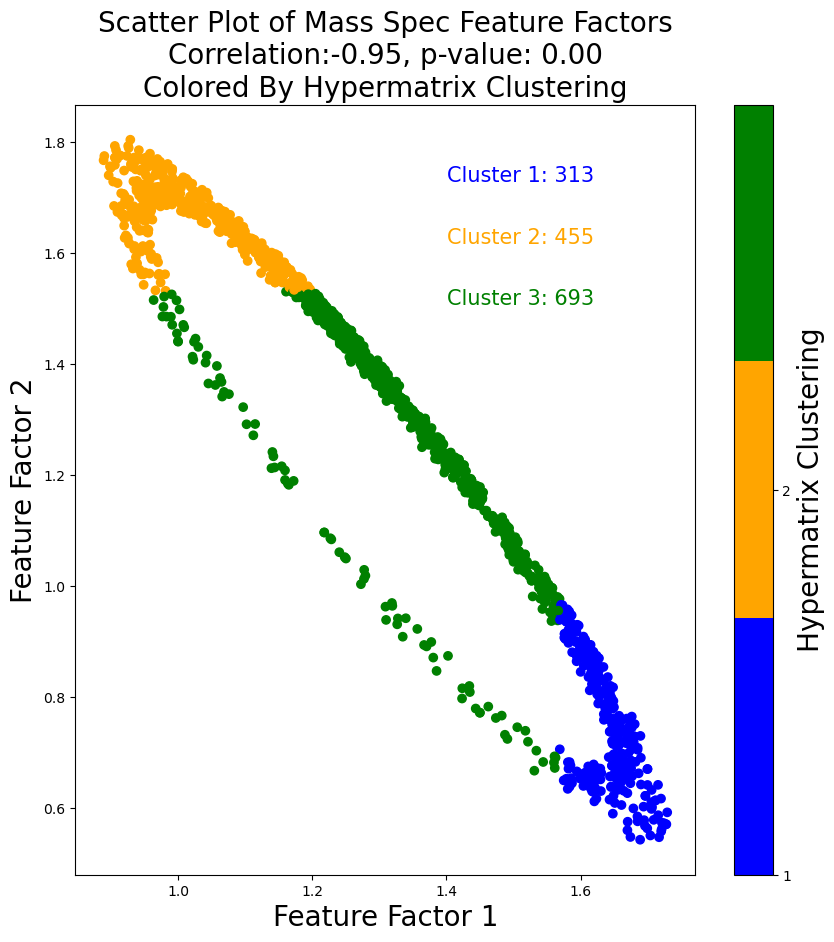

In [145]:
# Assuming you have feature_factor1 and feature_factor2 defined

# Calculate the mean values of feature_factor1 and feature_factor2 across all bins
mean_feature_factor1 = np.mean(feature_factor1)
mean_feature_factor2 = np.mean(feature_factor2)

# Loop over each bin and compare the values of feature_factor1 and feature_factor2 to the mean values to determine the category
categories = []
for i in range(len(feature_factor1)):
    if feature_factor1[i] > 1.2*mean_feature_factor1 and feature_factor2[i] < mean_feature_factor2:
        categories.append(1)
    elif feature_factor2[i] > 1.2*mean_feature_factor2 and feature_factor1[i] < mean_feature_factor1:
        categories.append(2)
    else:
        categories.append(3)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
#fig.suptitle(f'Factors from Mass Spec', fontsize=30)

# Calculate the correlation and p-value
correlation, p_value = pearsonr(feature_factor1, feature_factor2)

# Customize the color mapping for 8 discrete clusters
cluster_colors = ListedColormap(['b', 'orange', 'green'])
scatter = ax1.scatter(feature_factor1, feature_factor2, c=categories, cmap=cluster_colors)
ax1.set_title(f'Scatter Plot of Mass Spec Feature Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}\nColored By Hypermatrix Clustering', fontsize=20)
cbar = plt.colorbar(scatter, ax=ax1, ticks=range(1,3))  #
cbar.set_label('Hypermatrix Clustering', fontsize=20)

# Calculate the size of each cluster
cluster_sizes = [np.sum([category == i for category in categories]) for i in range(1,4)]  

# Display the size of each cluster
for i, size in enumerate(cluster_sizes):
    ax1.text(0.6, 0.9 - i * 0.08, f'Cluster {i+1}: {size}', transform=ax1.transAxes, fontsize=15, color=cluster_colors(i))

ax1.set_xlabel('Feature Factor 1', fontsize=20)
ax1.set_ylabel('Feature Factor 2', fontsize=20)

plt.show()

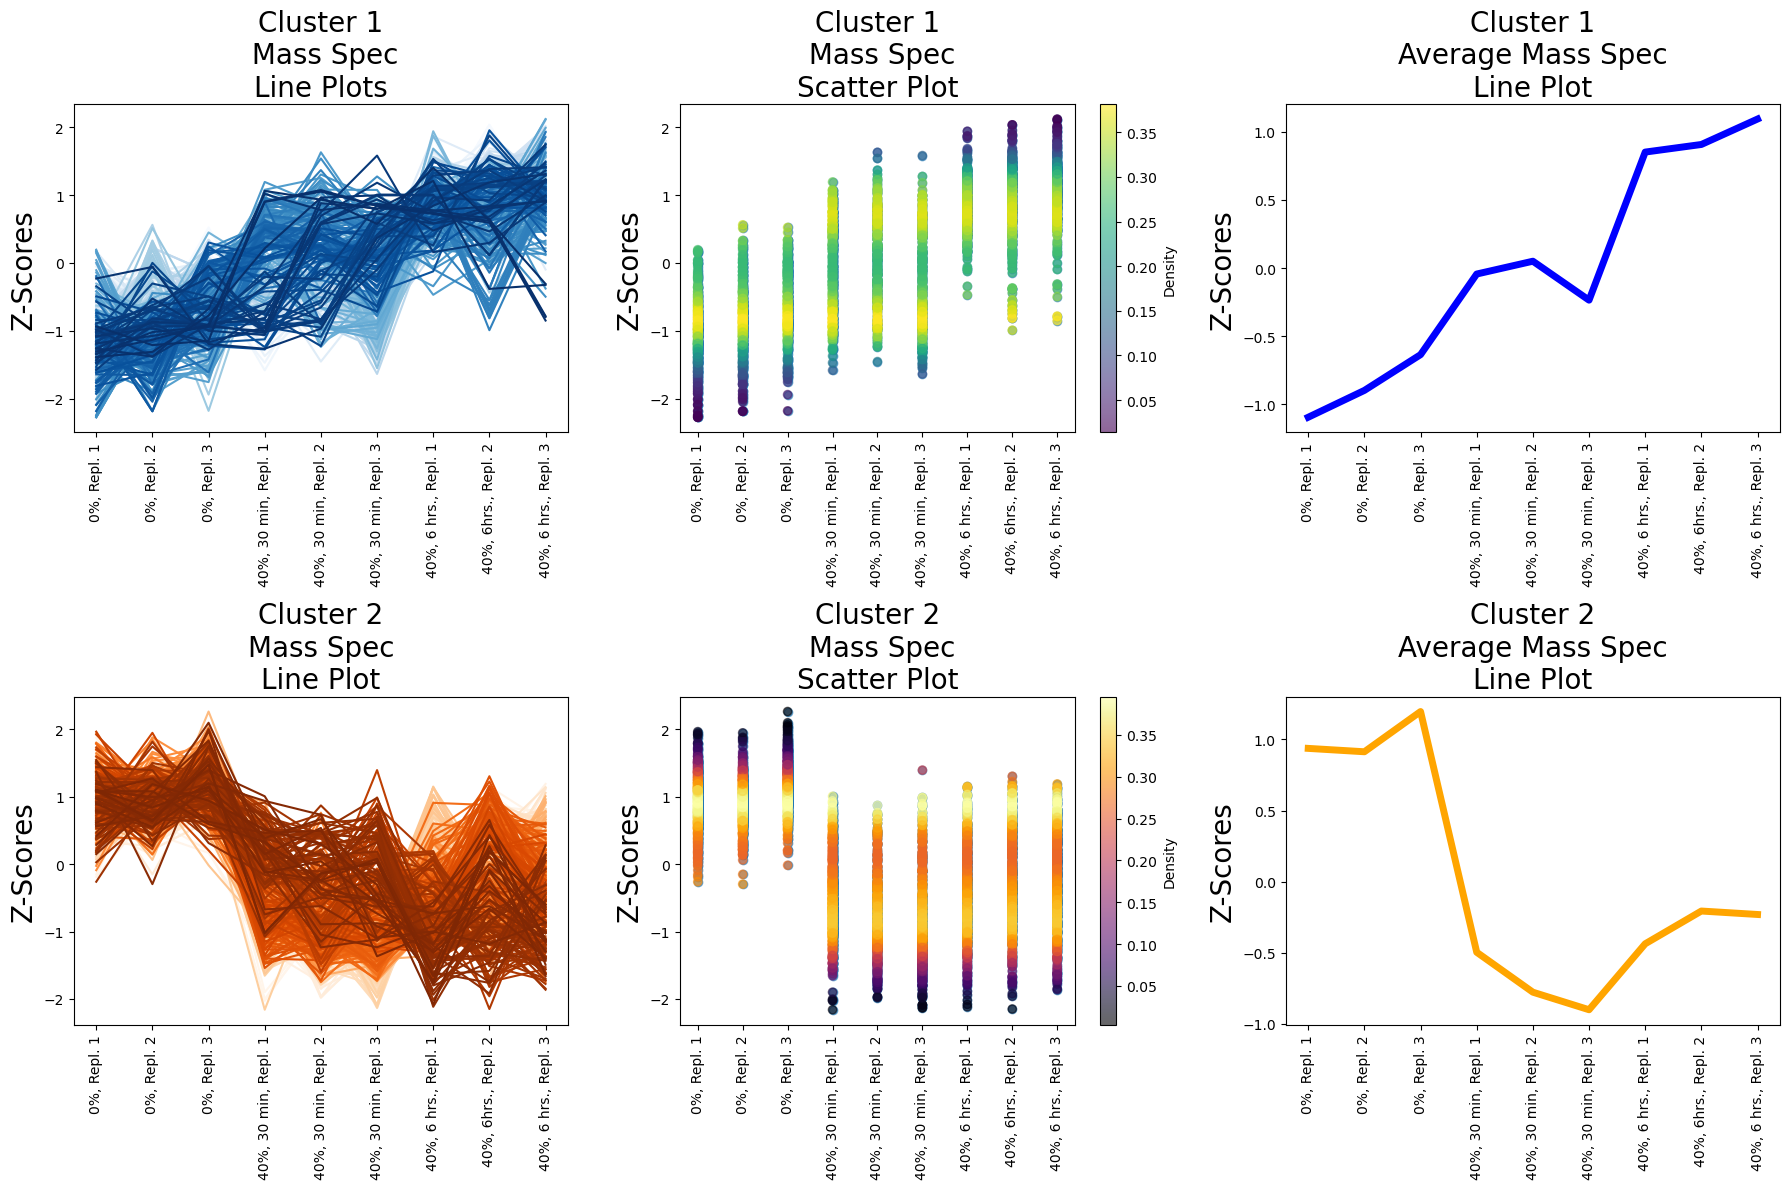

In [146]:
#This code plots the expression levels of the Two Clusters

# Create a list to store the vectors
vectors_category1 = []
vectors_category2 = []
vectors_category3 = []

# Iterate through the categories and extract vectors for categories[i] == 1
for i in range(len(categories)):
    if categories[i] == 1:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category1.append(vector) 
    if categories[i] == 2:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category2.append(vector)
    else:
        vector = [
            column_5[i],
            column_6[i],
            column_7[i],
            column_8[i],
            column_9[i],
            column_10[i],
            column_11[i],
            column_12[i],
            column_13[i]
        ]
        vectors_category3.append(vector)
        
vectors_category1_array = np.array(vectors_category1)
vectors_category2_array = np.array(vectors_category2)
vectors_category3_array = np.array(vectors_category3)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
colors_category1 = plt.cm.Blues(np.linspace(0, 1, len(vectors_category1_array)))
colors_category2 = plt.cm.Oranges(np.linspace(0, 1, len(vectors_category2_array)))
x_labels = ['0%, Repl. 1', '0%, Repl. 2', '0%, Repl. 3', '40%, 30 min, Repl. 1', '40%, 30 min, Repl. 2', '40%, 30 min, Repl. 3', '40%, 6 hrs., Repl. 1', '40%, 6hrs., Repl. 2', '40%, 6 hrs., Repl. 3']
x_values = np.arange(len(vectors_category2_array[0]))

# [0,0] subplot
for i, (vector, color) in enumerate(zip(vectors_category1_array, colors_category1)):
    axs[0, 0].plot(vector, label=f'Cluster 1', color=color)
axs[0, 0].set_xticks(range(len(x_labels)))
axs[0, 0].set_xticklabels(x_labels, rotation='vertical')
axs[0, 0].set_ylabel('Z-Scores', fontsize=20)
axs[0, 0].set_title('Cluster 1\n Mass Spec\nLine Plots', fontsize=20)

# [0,1] subplot
n = len(vectors_category1_array)
x = np.tile(np.arange(0,9), n)
y = np.hstack(vectors_category1_array)  
scatter = axs[0, 1].scatter(x, y, marker='o', alpha=0.6)
kde = gaussian_kde(y)
density = kde(y)
scatter = axs[0, 1].scatter(x, y, c=density, cmap='viridis', marker='o', alpha=0.6)
cbar = fig.colorbar(scatter, ax=axs[0, 1], label='Density')
axs[0, 1].set_xticks(range(len(x_labels)))
axs[0, 1].set_xticklabels(x_labels, rotation='vertical')
axs[0, 1].set_ylabel('Z-Scores', fontsize=20)
axs[0, 1].set_title('Cluster 1\n Mass Spec\nScatter Plot', fontsize=20)

# [0,2] subplot
average_vector_category1 = np.mean(vectors_category1_array, axis=0)
line = axs[0, 2].plot(average_vector_category1, label='Average Cluster 1', color='blue')
axs[0, 2].set_xticks(range(len(x_labels)))
axs[0, 2].set_xticklabels(x_labels, rotation='vertical')
axs[0, 2].set_ylabel('Z-Scores', fontsize=20)
axs[0, 2].set_title('Cluster 1\nAverage Mass Spec\nLine Plot', fontsize=20)
line[0].set_linewidth(5.0)

# [1,0] subplot
for i, (vector, color) in enumerate(zip(vectors_category2_array, colors_category2)):
    axs[1, 0].plot(vector, label=f'Cluster 2', color=color)
axs[1, 0].set_ylabel('Z-Scores', fontsize=20)
axs[1, 0].set_title('Cluster 2\nMass Spec\nLine Plot', fontsize=20)
axs[1, 0].set_xticks(range(len(x_labels)))
axs[1, 0].set_xticklabels(x_labels, rotation='vertical')

# [1,1] subplot
n = len(vectors_category2_array)
x = np.tile(np.arange(0, 9), n)
y = np.hstack(vectors_category2_array)  
scatter = axs[1, 1].scatter(x, y, marker='o', alpha=0.6)
kde = gaussian_kde(y)
density = kde(y)
scatter = axs[1, 1].scatter(x, y, c=density, cmap='inferno', marker='o', alpha=0.6)
cbar = fig.colorbar(scatter, ax=axs[1, 1], label='Density')
axs[1, 1].set_xticks(range(len(x_labels)))
axs[1, 1].set_xticklabels(x_labels, rotation='vertical')
axs[1, 1].set_ylabel('Z-Scores', fontsize=20)
axs[1, 1].set_title('Cluster 2\n Mass Spec\nScatter Plot', fontsize=20)




# [1,2] subplot
average_vector_category2 = np.mean(vectors_category2_array, axis=0)
line = axs[1, 2].plot(average_vector_category2, label='Average Cluster 2', color='orange')
axs[1, 2].set_ylabel('Z-Scores', fontsize=20)
axs[1, 2].set_title('Cluster 2\nAverage Mass Spec\nLine Plot',fontsize=20)
axs[1, 2].set_xticks(range(len(x_labels)))
axs[1, 2].set_xticklabels(x_labels, rotation='vertical')
line[0].set_linewidth(5.0)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


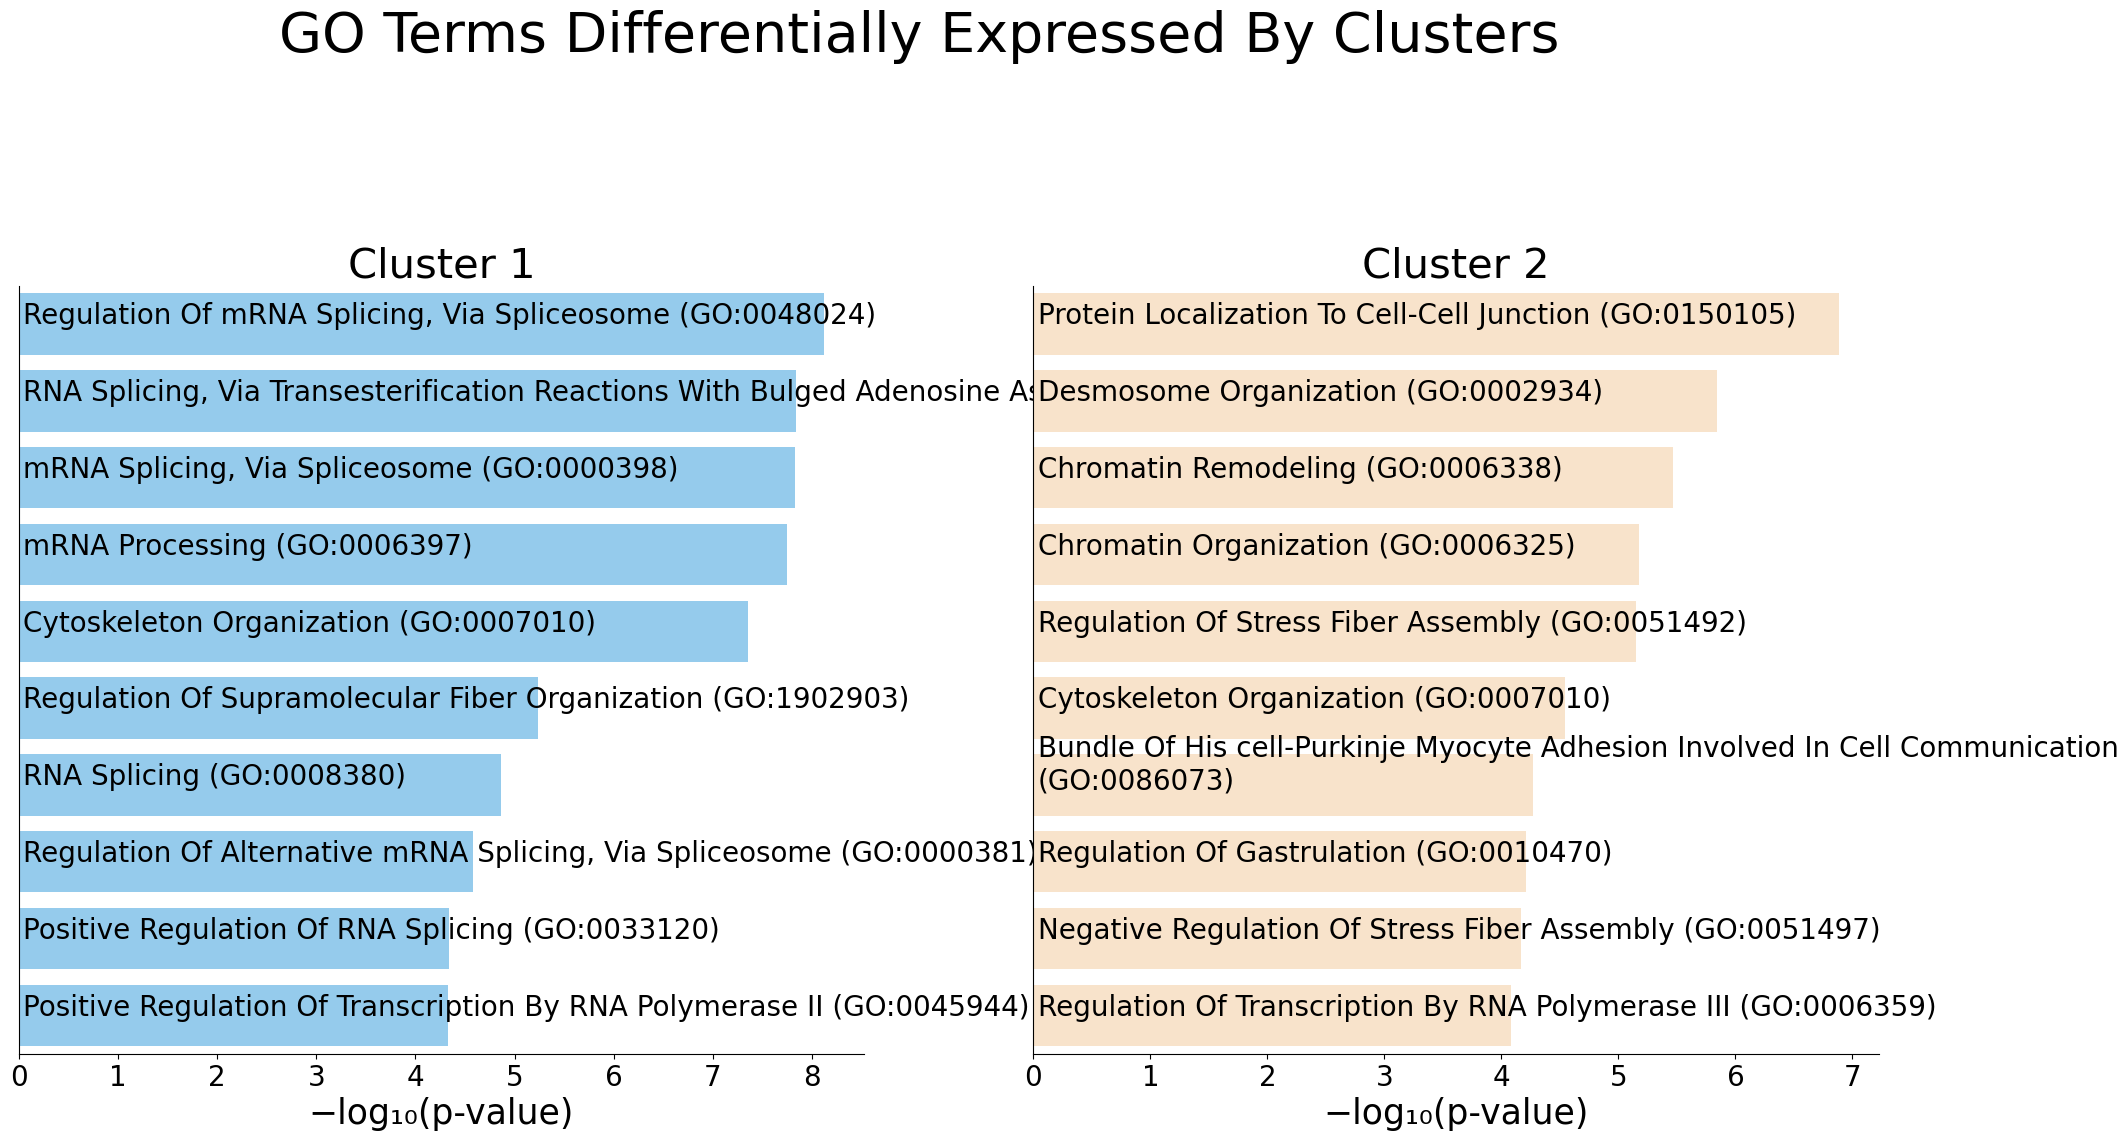

**Figure 1. Bar chart of top enriched terms from the GO_Biological_Process_2023 gene set library.** The top 10     enriched for GO terms are displayed based on the -log10(p-value).

/projects/b1198/epifluidlab/david/GSE143519/DE_Pathways.png

/projects/b1198/epifluidlab/david/GSE143519/DE_Pathways.svg

In [147]:
# Bar Chart Parameters
figure_file_format = ['png', 'svg']
output_file_name = 'DE_Pathways'
color = 'lightskyblue'
final_output_file_names = ['{0}.{1}'.format(output_file_name, file_type) for file_type in figure_file_format]
#enrichr_library = 'MSigDB_Hallmark_2020'
enrichr_library = 'GO_Biological_Process_2023'
#enrichr_library = 'GO_Cellular_Component_2023'

# Initialize a dictionary to store lists for each category
category_lists = {1: [], 2: [], 3: []}

# Iterate through the vectors and populate the lists
for gene, category in zip(gene_names, categories):
    gene = gene.strip()  # Remove trailing whitespace
    category_lists[category].append(gene)    
    
# Access the lists for each category
list1 = category_lists[1]
list2 = category_lists[2]
list3 = category_lists[3]

genes_de_factor1 = [x.strip() for x in list1]
genes_de_factor2 = [x.strip() for x in list2]

genes_upregulated = genes_de_factor1
genes_downregulated = genes_de_factor2 

# Error handling
class NoResults(Exception):
    pass 
class APIFailure(Exception):
    pass

# Enrichr API Function for Manhattan Plot and Bar Chart
# Takes a gene list and Enrichr libraries as input
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    for library_name in all_libraries : 
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = ''
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)

        if len(data[library_name]) == 0:
            raise NoResults

        short_results_df  = pd.DataFrame(data[library_name][0:10])
        all_terms.append(list(short_results_df[1]))
        all_pvalues.append(list(short_results_df[2]))
        all_adjusted_pvalues.append(list(short_results_df[6]))
        
        results_df  = pd.DataFrame(data[library_name])
        # adds library name to the data frame so the libraries can be distinguished
        results_df['library'] = library_name.replace('_', '')

    return [results_df, short_results_df, all_terms, all_pvalues, all_adjusted_pvalues, str(short_id)]

def enrichr_double_figure(up_terms, up_pvalues, up_adjusted_pvalues, down_terms, down_pvalues, down_adjusted_pvalues, plot_names, all_libraries, up_title, down_title):
    # Set bar colors
    edgecolor=None
    linewidth=0
    up_bar_color =  'lightskyblue'  #shade of red
    down_bar_color = 'bisque'  #shade of blue
    bar_color_not_sig = 'lightgrey'
    
    plt.figure(figsize=(24, 12))

    # Add a title to the figure
    plt.suptitle("GO Terms Differentially Expressed By Clusters", fontsize=40)
    plt.subplots_adjust(top=0.75)
    # Flatten the nested lists of terms
    up_terms_flat = [term for sublist in up_terms for term in sublist]
    down_terms_flat = [term for sublist in down_terms for term in sublist]

    # Flatten the nested lists of p-values
    up_pvalues_flat = [p for sublist in up_pvalues for p in sublist]
    down_pvalues_flat = [p for sublist in down_pvalues for p in sublist]

    # Plot for factor 1 genes
    plt.subplot(1, 2, 1)
    up_bar_colors = [up_bar_color if (x < 0.05) else bar_color_not_sig for x in up_pvalues_flat]
    up_fig = sns.barplot(x=np.log10(up_pvalues_flat) * -1, y=up_terms_flat, palette=up_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    up_fig.axes.get_yaxis().set_visible(False)
    up_fig.set_title(up_title, fontsize=30)
    up_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    up_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    up_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(up_pvalues_flat) * -1) < 1:
        up_fig.xaxis.set_ticks(np.arange(0, max(np.log10(up_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(up_terms_flat):
        title_start = max(up_fig.axes.get_xlim()) / 200
        up_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=20)
    up_fig.spines['right'].set_visible(False)
    up_fig.spines['top'].set_visible(False)

    # Plot for factor 1 genes
    plt.subplot(1, 2, 2)
    down_bar_colors = [down_bar_color if (x < 0.05) else bar_color_not_sig for x in down_pvalues_flat]
    down_fig = sns.barplot(x=np.log10(down_pvalues_flat) * -1, y=down_terms_flat, palette=down_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    down_fig.axes.get_yaxis().set_visible(False)
    down_fig.set_title(down_title, fontsize=30)
    down_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    down_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    down_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(down_pvalues_flat) * -1) < 1:
        down_fig.xaxis.set_ticks(np.arange(0, max(np.log10(down_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(down_terms_flat):
        title_start = max(down_fig.axes.get_xlim()) / 200
        down_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=20)
    down_fig.spines['right'].set_visible(False)
    down_fig.spines['top'].set_visible(False)

    for plot_name in plot_names:
        plt.savefig(plot_name, bbox_inches='tight')

    # Show plot
    plt.show()

    
#Display Bar Chart
caption5 = f"**Figure 1. Bar chart of top enriched terms from the {enrichr_library} gene set library.** The top 10 \
    enriched for GO terms are displayed based on the -log10(p-value)."

try:
    results_upregulated = Enrichr_API(genes_upregulated, [enrichr_library])
    results_downregulated = Enrichr_API(genes_downregulated, [enrichr_library])
    upregulated_title = 'Cluster 1'
    downregulated_title = 'Cluster 2'
    enrichr_double_figure(results_upregulated[2], results_upregulated[3], results_upregulated[4],
                      results_downregulated[2], results_downregulated[3], results_downregulated[4],
                      final_output_file_names, [enrichr_library], upregulated_title, downregulated_title)
    display(Markdown(caption5))
    # Download Bar Chart
    for i, file in enumerate(final_output_file_names):
        display(FileLink(file, result_html_prefix=str('Download ' + figure_file_format[i] + ': ')))
except APIFailure:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because of a bad response from the Enrichr API</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later."))
except NoResults:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))    